In [6]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json

# Load datasets
graduates_data = pd.read_csv('../data/graduates-major-data.csv', sep=';')
students_data = pd.read_csv('../data/students-major-data.csv', sep=';')

# Define key variables for analysis
P_WOJ = graduates_data['P_WOJ']  # Województwo lokalizacji jednostki dydaktycznej
P_ME_ZAR = graduates_data['P_ME_ZAR']  # Mediana wynagrodzeń absolwentów
P_WWZ = graduates_data['P_WWZ']  # Względny Wskaźnik Zarobków
P_WWB = graduates_data['P_WWB']  # Względny Wskaźnik Bezrobocia
P_WWB_DOSW = graduates_data['P_WWB_DOSW']  # Wskaźnik Bezrobocia dla absolwentów z doświadczeniem
P_WWB_NDOSW = graduates_data['P_WWB_NDOSW']  # Wskaźnik Bezrobocia dla absolwentów bez doświadczenia
P_CZAS_PRACA_DOSW = graduates_data['P_CZAS_PRACA_DOSW']  # Czas do pierwszej pracy dla absolwentów z doświadczeniem
P_CZAS_PRACA_NDOSW = graduates_data['P_CZAS_PRACA_NDOSW']  # Czas do pierwszej pracy dla absolwentów bez doświadczenia
P_ME_ZAR_DOSW = graduates_data['P_ME_ZAR_DOSW']  # Mediana wynagrodzeń dla absolwentów z doświadczeniem
P_ME_ZAR_NDOSW = graduates_data['P_ME_ZAR_NDOSW']  # Mediana wynagrodzeń dla absolwentów bez doświadczenia
# P_N = students_data['P_N']  # Liczba studentów
P_N = graduates_data['P_N'] # Liczba absolwentów
P_POZIOM = graduates_data['P_POZIOM']  # Poziom studiów
P_FORMA = graduates_data['P_FORMA']  # Forma studiów
P_ROKDYP = graduates_data['P_ROKDYP'] # Rok ukończenia studiów
P_ROK_OD = students_data['P_ROK_OD'] # Rok rozpoczęcia studiów
P_KIERUNEK_NAZWA = graduates_data['P_KIERUNEK_NAZWA'] # Pełna nazwa kierunku
P_ME_ZAR_P1 = graduates_data['P_ME_ZAR_P1'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 1 roku po uzyskaniu dyplomu
P_ME_ZAR_P2 = graduates_data['P_ME_ZAR_P2'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 2 roku po uzyskaniu dyplomu
P_ME_ZAR_P3 = graduates_data['P_ME_ZAR_P3'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 3 roku po uzyskaniu dyplomu
P_ME_ZAR_P4 = graduates_data['P_ME_ZAR_P4'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 4 roku po uzyskaniu dyplomu
P_ME_ZAR_P5 = graduates_data['P_ME_ZAR_P5'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 5 roku po uzyskaniu dyplomu
P_N_SEMESTR = graduates_data['P_N_SEMESTR'] # Liczba semestrów
P_NAZWA_UCZELNI = graduates_data['P_NAZWA_UCZELNI'] # Nazwa uczelni

# Convert selected columns with numeric strings to float
for col in graduates_data.columns:
    if any(keyword in col for keyword in ['P_ME', 'P_WWZ', 'P_WWB', 'P_CZAS']):
        graduates_data[col] = graduates_data[col].astype(str).str.replace(',', '.')
        graduates_data[col] = pd.to_numeric(graduates_data[col], errors='coerce')


/tmp/ipykernel_4347/3397959169.py:9: DtypeWarning: Columns (13,14,15,16,17,18,19,57,59,61,63,65,67,81,83,85,87,89,91,105,106,108,109,111,112,114,115,117,118,120,121,135,136,138,139,141,142,144,145,147,148,150,151,165,166,168,169,171,172,174,175,177,178,180,181,195,196,198,199,201,202,204,205,207,208,210,211,225,226,229,230,232,233,235,236,238,239,241,242,256,257,259,260,262,263,265,266,268,269,271,272,288,299,300,301,303,304,306,307,309,310,312,313,315,316,330,331,337,338,340,341,343,344,346,347,349,350,364,365,367,368,370,371,373,374,376,377,379,380,394,395,403,404,406,407,409,410,412,413,415,416,430,431,433,434,436,437,439,440,442,443,445,446) have mixed types. Specify dtype option on import or set low_memory=False.
  graduates_data = pd.read_csv('../data/graduates-major-data.csv', sep=';')
/tmp/ipykernel_4347/3397959169.py:10: DtypeWarning: Columns (9,18,23,30,64,71,78,85,92,99,106,113,120) have mixed types. Specify dtype option on import or set low_memory=False.
  students_data = p

In [7]:
# Function to map a field to a category based on keywords
def add_field_column(dataframe, column_name):
    """
    Add a new column 'Dziedzina' to the given DataFrame based on keywords in the specified column.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame to modify.
        column_name (str): The name of the column containing course names.

    Returns:
        pd.DataFrame: The updated DataFrame with the new 'Dziedzina' column.
    """
    # Dictionary mapping phrases to fields
    keywords_to_dziedzina = {
        "Prawo": "Nauki prawne",
        "Psychol": "Psychologia",
        "Automat": "Automatyka",
        "Informat": "Informatyka",
        "Zarządzanie": "Zarządzanie",
        "lekarski": "Kierunek lekarski",
        "Ekonom": "Ekonomia",
        "Mechani": "Inżynieria mechaniczna",
        "Chem": "Chemia",
        "Budowni": "Inżynieria lądowa",
        "Archit": "Architektura",
        "Elektr": "Inżynieria elektryczna",
        "środowi": "Inżynieria środowiskowa",
    }
    
    # Function to assign a field based on keywords
    def assign_field(course_name):
        for keyword, field in keywords_to_dziedzina.items():
            if keyword.lower() in course_name.lower():  # Check if keyword exists in the course name
                return field
        return "Inne"  # Assign "Inne" if no match is found

    # Apply the function to create the new column
    dataframe['Dziedzina'] = dataframe[column_name].apply(assign_field)

    return dataframe

# Apply the function to the graduates_data DataFrame
graduates_data = add_field_column(graduates_data, 'P_KIERUNEK_NAZWA')

/tmp/ipykernel_4347/2849430647.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['Dziedzina'] = dataframe[column_name].apply(assign_field)


In [8]:
def add_adjusted_salary_columns(data, median_dict):
    """
    Adds columns to the graduates_data DataFrame where the value is
    P_ME_ZAR_P1 through P_ME_ZAR_P5 divided by the median salary based on the year in P_ROKDYP.

    Args:
        data (pd.DataFrame): The graduates_data DataFrame.
        median_dict (dict): A dictionary containing median salaries for specific years.

    Returns:
        pd.DataFrame: The updated DataFrame with the new columns.
    """
    # Define the corresponding salary and new column suffixes
    salary_columns = [f"P_ME_ZAR_P{i}" for i in range(1, 6)]
    adjusted_columns = [f"P_WWZ_P{i}" for i in range(1, 6)]

    # Function to calculate the adjusted salary for a specific column
    def calculate_adjusted_salary(row, salary_column, offset):
        year = row['P_ROKDYP'] + offset
        if year in median_dict:
            return row[salary_column] / median_dict[year]
        return None  # Return None if the year is not in the median dictionary

    # Loop through each salary column and create the corresponding adjusted column
    for i, (salary_col, adjusted_col) in enumerate(zip(salary_columns, adjusted_columns), start=1):
        offset = i  # P_ME_ZAR_P1 corresponds to +1 year, P_ME_ZAR_P2 to +2 years, etc.
        data[adjusted_col] = data.apply(lambda row: calculate_adjusted_salary(row, salary_col, offset), axis=1)

    return data

# Define the median dictionary
median = {
2014: 3291.56,
2015: 3401.11,
2016: 3510.67,
2017: 3802.82,
2018: 4094.98,
2019: 4398.82,
2020: 4702.66,
2021: 5202.14,
2022: 5701.62,
2023: 6100.81,
2024: 6500.00
}

# Add the new column to graduates_data
graduates_data = add_adjusted_salary_columns(graduates_data, median)

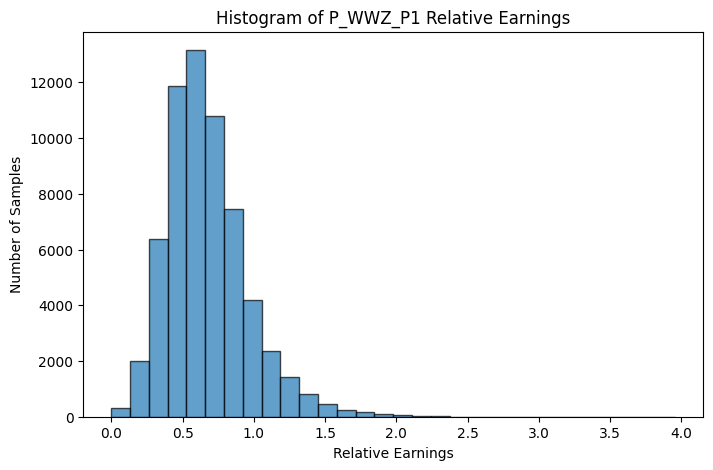

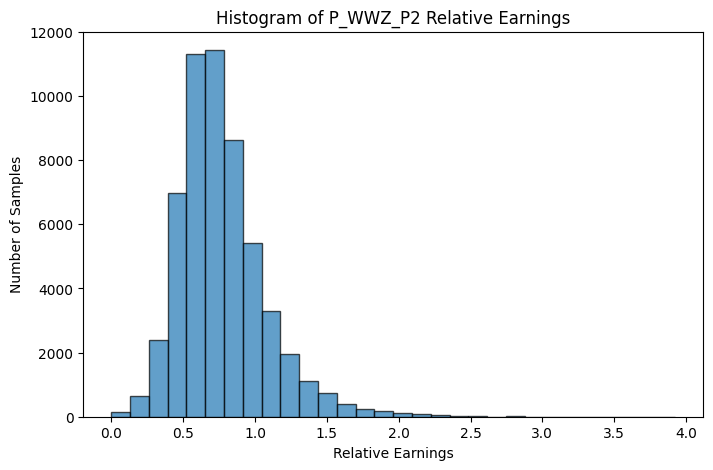

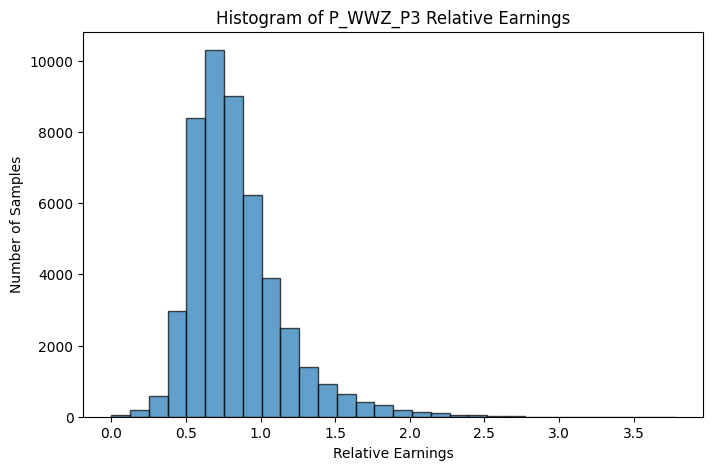

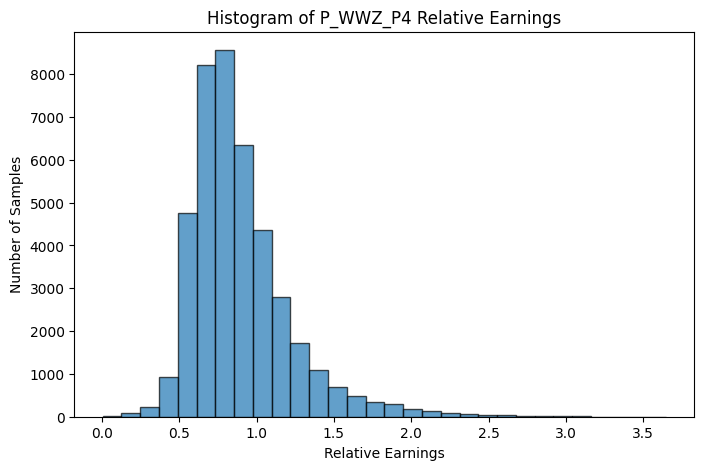

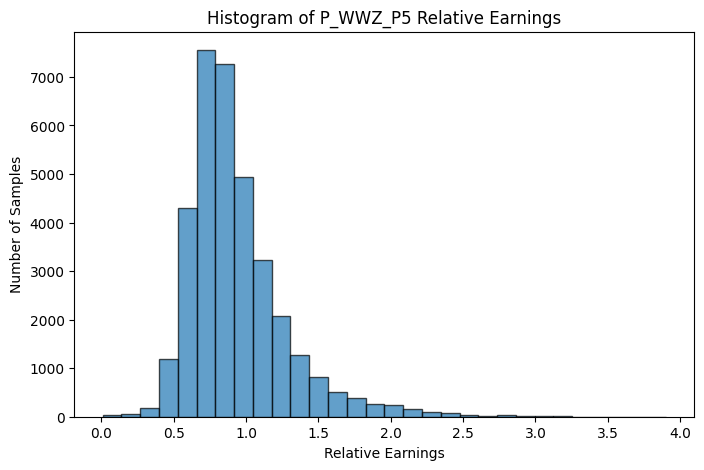

In [9]:
def plot_relative_salary_histograms(data, column_prefix="P_WWZ_P"):
    """
    Plots histograms for the relative salary columns (e.g., P_WWZ_P1 to P_WWZ_P5).

    Args:
        data (pd.DataFrame): The DataFrame containing the relative salary columns.
        column_prefix (str): The prefix of the columns to plot (default is 'P_WWZ_P').

    Returns:
        None: Displays the histograms.
    """
    # Import necessary libraries
    import matplotlib.pyplot as plt

    # Loop through the columns P_WWZ_P1 to P_WWZ_P5
    for i in range(1, 6):
        column = f"{column_prefix}{i}"
        if column in data.columns:
            # Drop NaN values for the current column
            column_data = data[column].dropna()

            # Plot the histogram
            plt.figure(figsize=(8, 5))
            plt.hist(column_data, bins=30, edgecolor='black', alpha=0.7)

            # Set plot labels and title
            plt.xlabel("Relative Earnings")
            plt.ylabel("Number of Samples")
            plt.title(f"Histogram of {column} Relative Earnings")

            # Show the plot
            plt.show()

# Example usage
plot_relative_salary_histograms(graduates_data)


In [10]:
# Create a dictionary to store mappings for each column
label_mappings = {}

# Encode variables and save mappings
for column in ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']:
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit and transform the column
    graduates_data[column] = label_encoder.fit_transform(graduates_data[column])
    
    # Store the mapping: original value -> encoded value
    label_mappings[column] = {str(original): encoded for encoded, original in enumerate(label_encoder.classes_)}

# # Save mappings to a file (optional)
# import json
with open('label_mappings.json', 'w', encoding='utf-8') as f:
    json.dump(label_mappings, f, ensure_ascii=False, indent=4)

# Print the mappings
for column, mapping in label_mappings.items():
    print(f"Mapping for {column}:")
    for original, encoded in mapping.items():
        print(f"  {original}: {encoded}")

Mapping for P_WOJ:
  2.0: 0
  4.0: 1
  6.0: 2
  8.0: 3
  10.0: 4
  12.0: 5
  14.0: 6
  16.0: 7
  18.0: 8
  20.0: 9
  22.0: 10
  24.0: 11
  26.0: 12
  28.0: 13
  30.0: 14
  32.0: 15
  nan: 16
Mapping for P_POZIOM:
  1: 0
  2: 1
  JM: 2
Mapping for P_FORMA:
  N: 0
  S: 1
Mapping for Dziedzina:
  Architektura: 0
  Automatyka: 1
  Chemia: 2
  Ekonomia: 3
  Informatyka: 4
  Inne: 5
  Inżynieria elektryczna: 6
  Inżynieria lądowa: 7
  Inżynieria mechaniczna: 8
  Inżynieria środowiskowa: 9
  Kierunek lekarski: 10
  Nauki prawne: 11
  Psychologia: 12
  Zarządzanie: 13


In [ ]:
import json

# Path to the .json file
file_path = 'label_mappings.json'

# Load the .json file
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Now `data` is a regular Python dictionary
print(type(data))  # <class 'dict'>
print(data)

# Function to find a key based on a value
def get_key_from_value(mapping, value):
    reverse_mapping = {v: k for k, v in mapping.items()}
    return reverse_mapping.get(value, "Value not found")

# Example usage
value_to_find = 0
result = get_key_from_value(data['P_FORMA'], value_to_find)
print(result)

# MODELS

## STARY

Epoch 1/25, Training Loss: 0.2025, Validation Loss: 0.1594
Epoch 2/25, Training Loss: 0.1486, Validation Loss: 0.1458
Epoch 3/25, Training Loss: 0.1392, Validation Loss: 0.1356
Epoch 4/25, Training Loss: 0.1309, Validation Loss: 0.1264
Epoch 5/25, Training Loss: 0.1224, Validation Loss: 0.1148
Epoch 6/25, Training Loss: 0.1140, Validation Loss: 0.1248
Epoch 7/25, Training Loss: 0.1092, Validation Loss: 0.1332
Epoch 8/25, Training Loss: 0.1050, Validation Loss: 0.1082
Epoch 9/25, Training Loss: 0.1051, Validation Loss: 0.0967
Epoch 10/25, Training Loss: 0.1002, Validation Loss: 0.0985
Epoch 11/25, Training Loss: 0.0997, Validation Loss: 0.0990
Epoch 12/25, Training Loss: 0.0976, Validation Loss: 0.1020
Epoch 13/25, Training Loss: 0.0977, Validation Loss: 0.0972
Epoch 14/25, Training Loss: 0.0962, Validation Loss: 0.0952
Epoch 15/25, Training Loss: 0.0952, Validation Loss: 0.0938
Epoch 16/25, Training Loss: 0.0962, Validation Loss: 0.0950
Epoch 17/25, Training Loss: 0.0943, Validation Lo

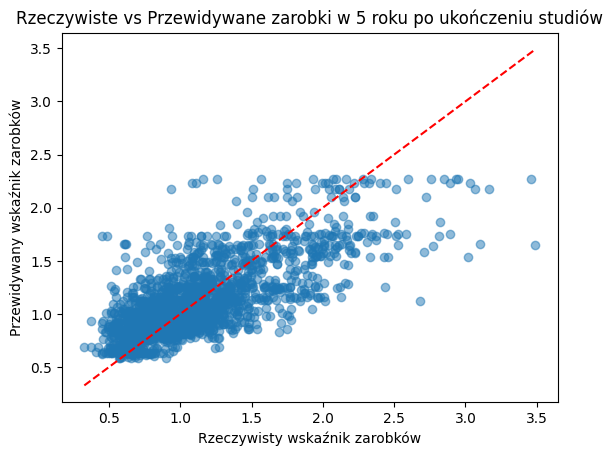

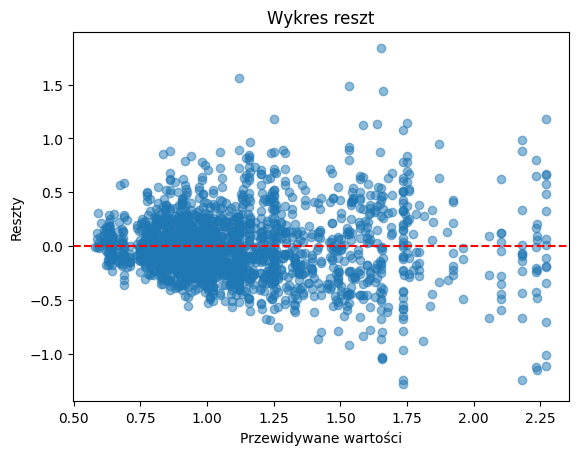

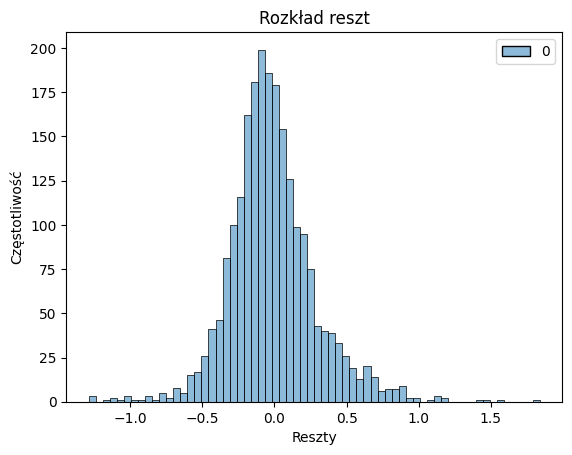

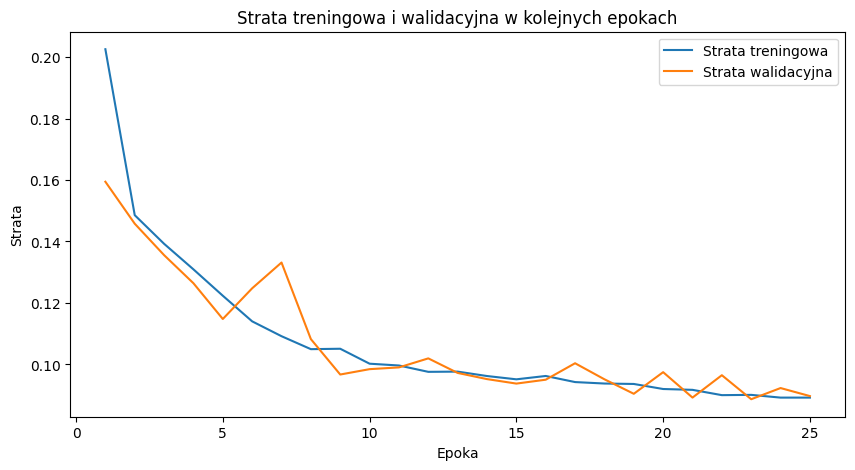

In [87]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

year = 5

# Assuming 'graduates_data' is your DataFrame loaded from a CSV or other source
# Replace this with your actual data loading code
# graduates_data = pd.read_csv('your_data.csv')

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Drop rows with missing values in specified columns
columns_to_check = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina', f'P_WWZ_P{year}']
graduates_data_copy = graduates_data_copy.dropna(subset=columns_to_check)

# List of categorical features
categorical_features = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']

# Label Encoding for categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

# Features and target variable
features = graduates_data_copy[categorical_features]
target = graduates_data_copy[f'P_WWZ_P{year}']

# Convert to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Custom Dataset
class GraduatesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define your RegressionModel
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)        # Second hidden layer
        self.fc3 = nn.Linear(64, 32)         # Third hidden layer
        self.fc4 = nn.Linear(32, 1)          # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model_old = RegressionModel(input_dim=len(categorical_features))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_old.parameters(), lr=0.001)

# Create datasets
train_dataset = GraduatesDataset(X_train, y_train)
test_dataset = GraduatesDataset(X_test, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
epochs = 25  # Number of epochs
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model_old.train()
    epoch_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_old(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_x.size(0)
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model_old.eval()
    epoch_valid_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            outputs = model_old(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_valid_loss += loss.item() * batch_x.size(0)
    epoch_valid_loss /= len(valid_loader.dataset)
    valid_losses.append(epoch_valid_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_valid_loss:.4f}")


# Evaluate the model on the test set
model_old.eval()
with torch.no_grad():
    test_predictions = model_old(X_test).numpy()
    y_test_actual = y_test.numpy()

# Calculate regression metrics
mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predictions)
mape = mean_absolute_percentage_error(y_test_actual, test_predictions)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(y_test_actual, test_predictions, alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki w {year} roku po ukończeniu studiów")
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    'r--'
)  # Line y=x
plt.show()

residuals = y_test_actual - test_predictions
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty")
plt.title("Wykres reszt")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


sns.histplot(residuals, kde=False)
plt.title("Rozkład reszt")
plt.xlabel("Reszty")
plt.ylabel("Częstotliwość")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()


In [88]:
def predict_year5_old(model, data, input_features):
    """
    Predicts the WWZ value for year 5 based on the given input features.

    Args:
        model (torch.nn.Module): Trained PyTorch regression model.
        data (pd.DataFrame): Original graduates data.
        input_features (dict): Dictionary of input features, e.g.,
            {
                'P_WOJ': 0,
                'P_POZIOM': 0,
                'P_FORMA': 1,
                'Dziedzina': 1
            }

    Returns:
        dict: Dictionary with keys:
            - "predicted" (float): Predicted value for year 5 WWZ.
            - "actual_median" (float): Median of actual values for matching rows.
            - "difference_pct" (float): Percentage difference between predicted and actual.
    """
    # Step 1: Filter rows matching the input features
    filtered_data = data.copy()
    for col, value in input_features.items():
        filtered_data = filtered_data[filtered_data[col] == value]

    # Step 2: Check if data exists for the given input features
    if filtered_data.empty:
        return {
            "predicted": None,
            "actual_median": None,
            "difference_pct": None,
        }

    # Step 3: Preprocess the input features
    categorical_features = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
    input_array = np.array([input_features[feat] for feat in categorical_features], dtype=np.float32)
    input_tensor = torch.tensor(input_array).unsqueeze(0)  # Shape: (1, input_dim)

    # Step 4: Predict the year 5 WWZ using the model
    model.eval()
    with torch.no_grad():
        predicted_value = model(input_tensor).item()

    # Step 5: Calculate the median of actual values
    actual_values = filtered_data[f'P_WWZ_P{year}'].values
    actual_median = np.median(actual_values)

    # Step 6: Compute the percentage difference
    difference_pct = ((predicted_value - actual_median) / actual_median) * 100

    return {
        "predicted": predicted_value,
        "actual_median": actual_median,
        "difference_pct": difference_pct,
    }


In [89]:
input_features = {
    'P_WOJ': 0,
    'P_POZIOM': 0,
    'P_FORMA': 1,
    'Dziedzina': 1
}

result = predict_year5_old(model_old, graduates_data_copy, input_features)

pred_val = result["predicted"]
actual_val = result["actual_median"]
diff = result["difference_pct"]

if pred_val is not None:
    print(f"Predicted year 5 WWZ: {pred_val:.4f}")
    print(f"Median year 5 WWZ: {actual_val:.4f}")
    print(f"Difference in %: {diff:.2f}")
else:
    print("No data available for the given input_features.")


Predicted year 5 WWZ: 1.6389
Median year 5 WWZ: 1.4280
Difference in %: 14.77


## LSTM 1 warstwa

Train size: 8828
Validation size: 1103
Test size: 1104
Epoch [1/10] - Train Loss: 0.1389, Val Loss: 0.0473
Epoch [2/10] - Train Loss: 0.0324, Val Loss: 0.0243
Epoch [3/10] - Train Loss: 0.0199, Val Loss: 0.0176
Epoch [4/10] - Train Loss: 0.0169, Val Loss: 0.0163
Epoch [5/10] - Train Loss: 0.0161, Val Loss: 0.0158
Epoch [6/10] - Train Loss: 0.0157, Val Loss: 0.0156
Epoch [7/10] - Train Loss: 0.0158, Val Loss: 0.0157
Epoch [8/10] - Train Loss: 0.0155, Val Loss: 0.0157
Epoch [9/10] - Train Loss: 0.0155, Val Loss: 0.0158
Epoch [10/10] - Train Loss: 0.0154, Val Loss: 0.0152

*** Final Evaluation on Test Set ***
Test MSE:  0.0153
Test RMSE: 0.1237
Test MAE:  0.0846
Test MAPE: 0.0940
Test R^2:  0.9119


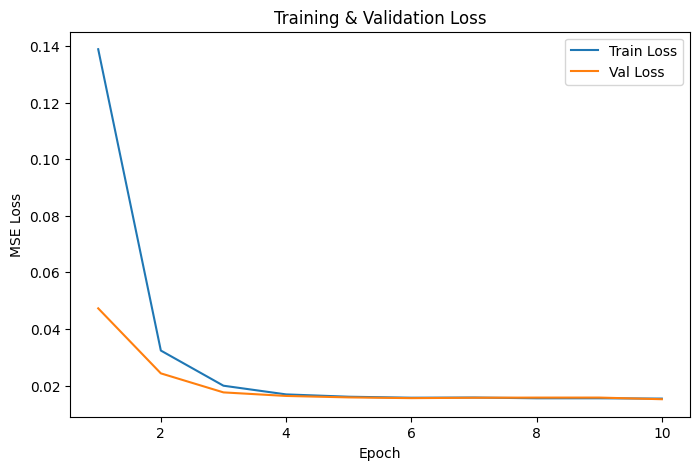

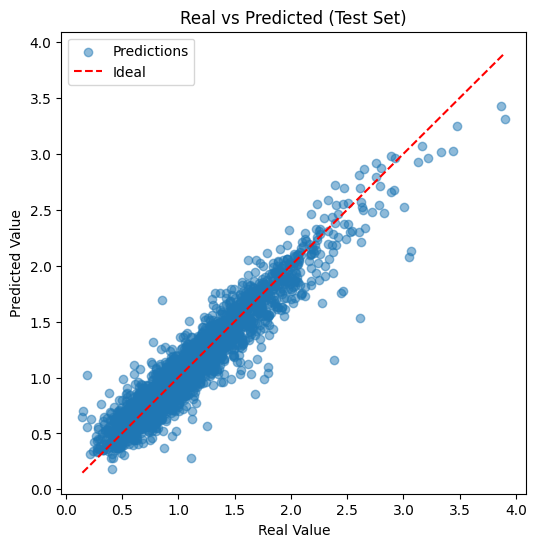

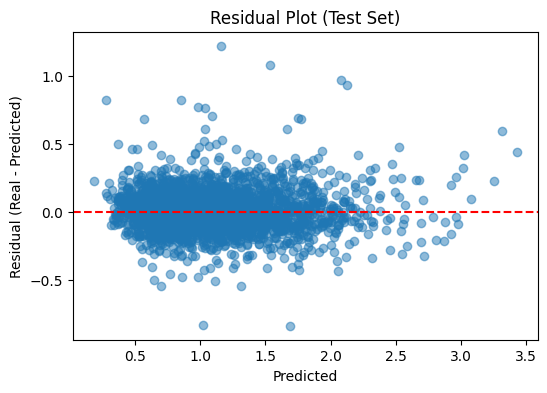

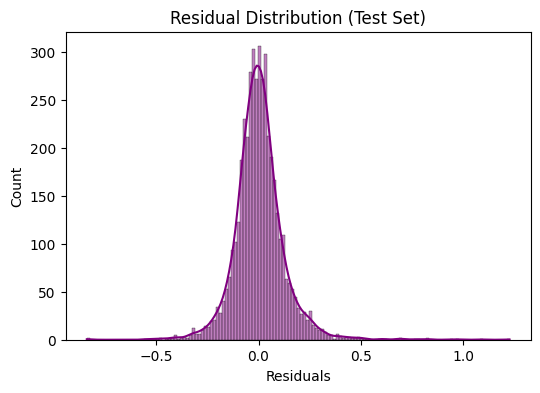

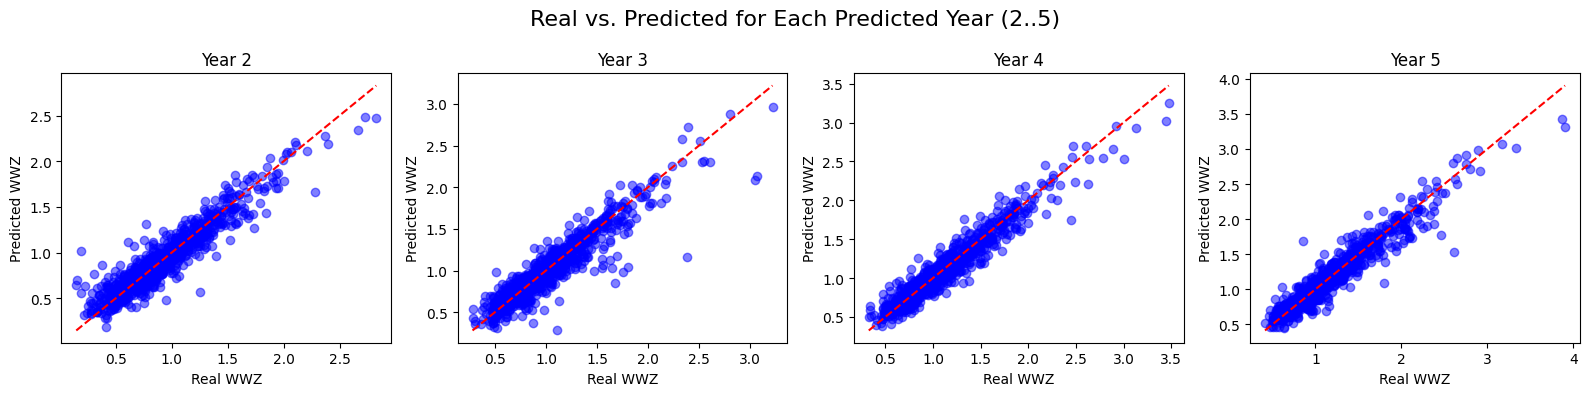

Per-Year Metrics (Years 2..5):
   Year       MSE      RMSE       MAE      MAPE        R2
0     2  0.014530  0.120540  0.085456  0.120136  0.889095
1     3  0.019015  0.137896  0.090333  0.098070  0.875391
2     4  0.011957  0.109349  0.078063  0.079783  0.932634
3     5  0.015692  0.125267  0.084464  0.077853  0.923876


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# ===================================================
# 1. Data Preparation
# ===================================================

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# ---------------------------------------
# Build sequences for each row
# ---------------------------------------
def build_sequences(row):
    """
    Builds a sequence of length 4 (features) and 4 targets from a row.
    
    For each time step t = 1..4:
      Input (X_t) = [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_Pt]
      Output (Y_t) = P_WWZ_P(t+1)
    """
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    wwz_values = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    
    seq_input = []
    seq_output = []
    
    # 4 time steps => 4 input steps, 4 targets
    for t in range(4):
        year_t = t + 1
        x_t = [woj, poziom, forma, dziedz, year_t, wwz_values[t]]
        seq_input.append(x_t)
        seq_output.append(wwz_values[t + 1])  # next year's WWZ
    
    return np.array(seq_input, dtype=np.float32), np.array(seq_output, dtype=np.float32)

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim=6)
all_targets = np.array(all_targets)      # shape: (N, 4)

# # ---------------------------------------
# # 1.1 Three Splits: Train, Validation, Test
# # ---------------------------------------
# # Step 1: Split off the test set (e.g., 20%)
# X_temp, X_test, y_temp, y_test = train_test_split(
#     all_sequences, all_targets,
#     test_size=0.2, random_state=42
# )

# # Step 2: Split the remaining 80% into train/validation (e.g., 80% => 64% train, 16% val)
# # So if you want 20% test, 10% val, 70% train, you can adjust:
# #   For example, val_size=(0.2 / 0.8)=0.25 => 75% train, 25% val (of the leftover 80%).
# val_size = 0.25  # 25% of the leftover => overall 20% test, 20% val, 60% train if you prefer
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp,
#     test_size=val_size, random_state=42
# )

X_train, X_temp, y_train, y_temp = train_test_split(
    all_sequences, all_targets,
    test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# ===================================================
# 2. Dataset and DataLoader
# ===================================================
class GraduatesLSTMDataset(Dataset):
    """
    A custom PyTorch Dataset for LSTM-based time series.
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return self.X.size(0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets for train, val, test
train_dataset = GraduatesLSTMDataset(X_train, y_train)
val_dataset   = GraduatesLSTMDataset(X_val,   y_val)
test_dataset  = GraduatesLSTMDataset(X_test,  y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# ===================================================
# 3. LSTM Model Definition
# ===================================================
class LSTMModel(nn.Module):
    """
    A simple LSTM model for many-to-many prediction.
    The model outputs a value for each time step.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first=True => input shape: (batch, seq_length, input_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Final fully-connected layer maps hidden states to 1D output
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Forward pass through the LSTM.
        
        Args:
            x (Tensor): shape (batch_size, seq_length, input_dim)
        
        Returns:
            Tensor of shape (batch_size, seq_length).
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out)  # (batch_size, seq_length, 1)
        return out.squeeze(-1)   # (batch_size, seq_length)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[2]  # e.g., 6
model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===================================================
# 4. Model Training (Now with Validation Set)
# ===================================================
epochs = 10
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    
    # -----------------------------
    # Training Loop
    # -----------------------------
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        preds = model(batch_x)  # shape: (batch_size, seq_length=4)
        loss = criterion(preds, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * batch_x.size(0)
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # -----------------------------
    # Validation Loop
    # -----------------------------
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            preds = model(batch_x)
            val_loss = criterion(preds, batch_y)
            total_val_loss += val_loss.item() * batch_x.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# ===================================================
# 5. Evaluation on the Test Set
# ===================================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
test_real  = torch.cat(test_y_list,   dim=0).numpy()    # shape: (N_test, 4)

# Flatten for metrics
test_preds_flat = test_preds.flatten()
test_real_flat  = test_real.flatten()

# -------------------------------------
# 5.1. Metrics
# -------------------------------------
mse  = mean_squared_error(test_real_flat, test_preds_flat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_real_flat, test_preds_flat)
mape = mean_absolute_percentage_error(test_real_flat, test_preds_flat)
r2   = r2_score(test_real_flat, test_preds_flat)

print("\n*** Final Evaluation on Test Set ***")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test R^2:  {r2:.4f}")

# -------------------------------------
# 5.2. Plots
# -------------------------------------
# (A) Training vs Validation Loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# (B) Real vs. Predicted scatter (Test Set)
plt.figure(figsize=(6,6))
plt.scatter(test_real_flat, test_preds_flat, alpha=0.5, label='Predictions')
plt.plot(
    [test_real_flat.min(), test_real_flat.max()],
    [test_real_flat.min(), test_real_flat.max()],
    'r--',
    label='Ideal'
)
plt.title("Real vs Predicted (Test Set)")
plt.xlabel("Real Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

# (C) Residuals: Real - Predicted
residuals = test_real_flat - test_preds_flat

plt.figure(figsize=(6,4))
plt.scatter(test_preds_flat, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Real - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()

# (D) Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

# Years that are predicted
predicted_years = [2, 3, 4, 5]

# 1) Create a plot with subplots for each predicted year
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Real vs. Predicted for Each Predicted Year (2..5)", fontsize=16)

for i, ax in enumerate(axes):
    year = predicted_years[i]       # 2, 3, 4, 5
    real_vals = test_real[:, i]     # Column i in test_real
    pred_vals = test_preds[:, i]    # Column i in test_preds

    ax.scatter(real_vals, pred_vals, alpha=0.5, color='blue')
    ax.plot(
        [real_vals.min(), real_vals.max()],
        [real_vals.min(), real_vals.max()],
        'r--'
    )
    ax.set_title(f"Year {year}")
    ax.set_xlabel("Real WWZ")
    ax.set_ylabel("Predicted WWZ")

plt.tight_layout()
plt.show()


# 2) Create a per-year metrics table (MSE, RMSE, MAE, MAPE, R2)
metrics_rows = []
for i, year in enumerate(predicted_years):
    # Extract real and predicted columns
    real_vals = test_real[:, i]
    pred_vals = test_preds[:, i]
    
    mse  = mean_squared_error(real_vals, pred_vals)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(real_vals, pred_vals)
    mape = mean_absolute_percentage_error(real_vals, pred_vals)
    r2   = r2_score(real_vals, pred_vals)
    
    metrics_rows.append({
        "Year": year,
        "MSE":  mse,
        "RMSE": rmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2
    })

df_metrics = pd.DataFrame(metrics_rows)
print("Per-Year Metrics (Years 2..5):")
print(df_metrics)

## Bidirectional LSTM

Train size: 8828
Validation size: 1103
Test size: 1104


/home/jkskw/git/ela_analysis/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/3] - Train Loss: 0.0517, Val Loss: 0.0129
Epoch [2/3] - Train Loss: 0.0229, Val Loss: 0.0097
Epoch [3/3] - Train Loss: 0.0220, Val Loss: 0.0081

*** Final Evaluation on Test Set ***
Test MSE:  0.0087
Test RMSE: 0.0934
Test MAE:  0.0615
Test MAPE: 0.0653
Test R^2:  0.9498


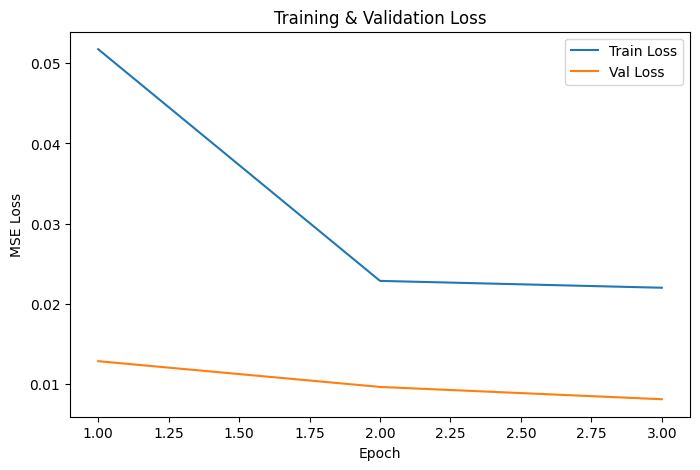

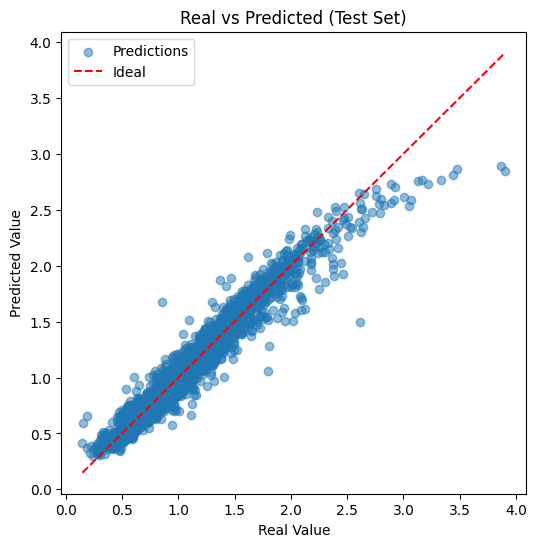

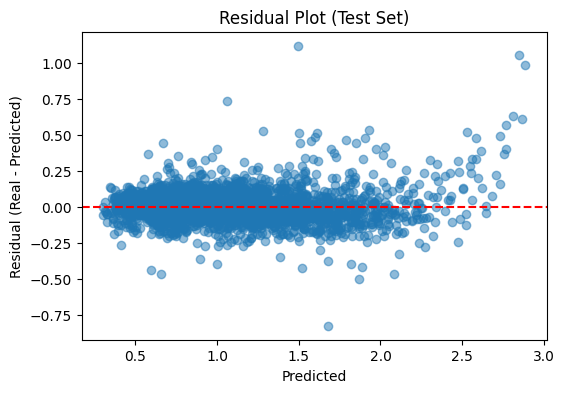

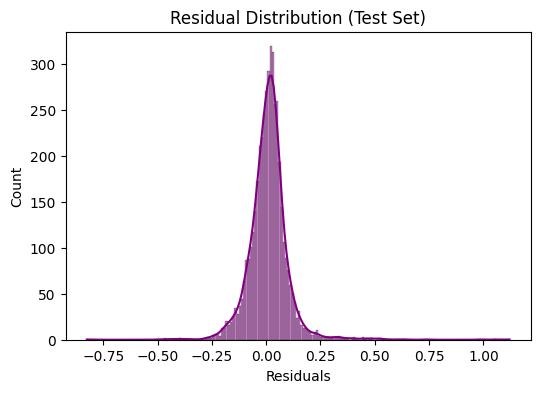

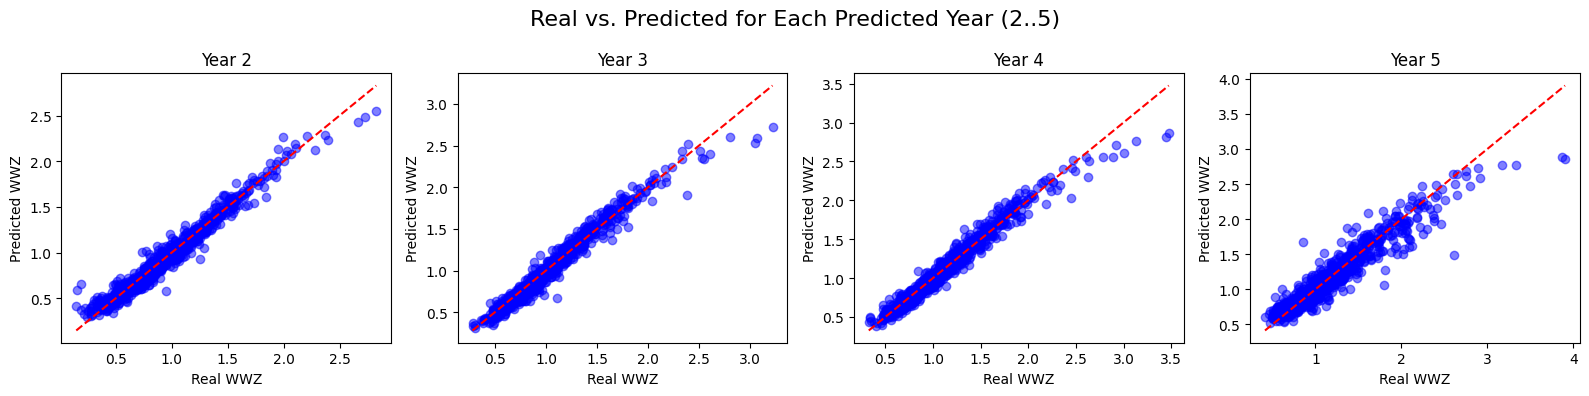

Per-Year Metrics (Years 2..5):
   Year       MSE      RMSE       MAE      MAPE        R2
0     2  0.004783  0.069161  0.049570  0.069571  0.963490
1     3  0.005243  0.072412  0.051482  0.054971  0.965639
2     4  0.005814  0.076248  0.053404  0.052748  0.967246
3     5  0.019031  0.137952  0.091374  0.084048  0.907678


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json  # if you need to load label mappings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# ===================================================
# 1. Data Preparation
# ===================================================

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

def build_sequences(row):
    """
    Builds a sequence of length 4 (features) and 4 targets from a row.
    
    For each time step t = 1..4:
      Input (X_t) = [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_Pt]
      Output (Y_t) = P_WWZ_P(t+1)
    """
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    wwz_values = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    
    seq_input = []
    seq_output = []
    
    # 4 time steps => 4 input steps, 4 targets
    for t in range(4):
        year_t = t + 1
        x_t = [woj, poziom, forma, dziedz, year_t, wwz_values[t]]
        seq_input.append(x_t)
        seq_output.append(wwz_values[t + 1])  # next year's WWZ
    
    return np.array(seq_input, dtype=np.float32), np.array(seq_output, dtype=np.float32)


# -----------------------------------------------------
# Build all_sequences / all_targets from DataFrame
# -----------------------------------------------------
all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim=6)
all_targets = np.array(all_targets)      # shape: (N, 4)

# ===========================================
# Step 1: Train/Test Split (80%/20%)
# ===========================================
X_train, X_temp, y_train, y_temp = train_test_split(
    all_sequences, all_targets,
    test_size=0.2, random_state=42
)

# ===========================================
# Step 2: Validation/Test Split (from 20%)
# ===========================================
# Divide the remaining 20% into equal halves
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


# ===================================================
# 2. Dataset and DataLoader
# ===================================================
class GraduatesLSTMDataset(Dataset):
    """
    A custom PyTorch Dataset for LSTM-based time series.
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return self.X.size(0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets for train, val, test
train_dataset = GraduatesLSTMDataset(X_train, y_train)
val_dataset   = GraduatesLSTMDataset(X_val,   y_val)
test_dataset  = GraduatesLSTMDataset(X_test,  y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


# ===================================================
# 3. Advanced LSTM Model Definition
# ===================================================
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(AdvancedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Batch Normalization
        self.bn = nn.BatchNorm1d(input_dim)
        
        # Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Fully-connected layer
        self.fc = nn.Linear(hidden_dim * 2, 1)  # bidirectional => hidden_dim*2

    def forward(self, x):
        # x.shape => (batch_size, seq_length=4, input_dim=6)
        # 1) Apply BatchNorm across input_dim dimension
        batch_size, seq_length, input_dim = x.size()
        
        # Flatten the (batch*seq, input_dim), apply BN, then reshape
        x = self.bn(x.view(-1, input_dim)).view(batch_size, seq_length, input_dim)
        
        # 2) LSTM forward
        lstm_out, _ = self.lstm(x)  # shape => (batch_size, seq_length, hidden_dim*2)
        
        # 3) FC layer => (batch_size, seq_length, 1)
        out = self.fc(lstm_out)
        return out.squeeze(-1)  # => (batch_size, seq_length)


# Initialize model
input_dim = X_train.shape[2]  # should be 6
model = AdvancedLSTMModel(
    input_dim=input_dim, 
    hidden_dim=128, 
    num_layers=3, 
    dropout=0.3
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)


# ===================================================
# 4. Model Training (Now with Validation Set)
# ===================================================
epochs = 3
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    
    # --- Training Loop ---
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * batch_x.size(0)
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            preds = model(batch_x)
            val_loss = criterion(preds, batch_y)
            total_val_loss += val_loss.item() * batch_x.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduler step
    scheduler.step(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


# ===================================================
# 5. Evaluation on the Test Set
# ===================================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape => (N_test, 4)
test_real  = torch.cat(test_y_list,   dim=0).numpy()    # shape => (N_test, 4)

# Flatten for metrics
test_preds_flat = test_preds.flatten()
test_real_flat  = test_real.flatten()

# -------------------------------------
# 5.1. Metrics
# -------------------------------------
mse  = mean_squared_error(test_real_flat, test_preds_flat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_real_flat, test_preds_flat)
mape = mean_absolute_percentage_error(test_real_flat, test_preds_flat)
r2   = r2_score(test_real_flat, test_preds_flat)

print("\n*** Final Evaluation on Test Set ***")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test R^2:  {r2:.4f}")


# -------------------------------------
# 5.2. Plots
# -------------------------------------
# (A) Training vs Validation Loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# (B) Real vs. Predicted scatter (Test Set)
plt.figure(figsize=(6,6))
plt.scatter(test_real_flat, test_preds_flat, alpha=0.5, label='Predictions')
plt.plot(
    [test_real_flat.min(), test_real_flat.max()],
    [test_real_flat.min(), test_real_flat.max()],
    'r--',
    label='Ideal'
)
plt.title("Real vs Predicted (Test Set)")
plt.xlabel("Real Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

# (C) Residuals: Real - Predicted
residuals = test_real_flat - test_preds_flat

plt.figure(figsize=(6,4))
plt.scatter(test_preds_flat, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Real - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()

# (D) Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

# Years that are predicted
predicted_years = [2, 3, 4, 5]

# 1) Create a plot with subplots for each predicted year
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Real vs. Predicted for Each Predicted Year (2..5)", fontsize=16)

for i, ax in enumerate(axes):
    year = predicted_years[i]       # 2, 3, 4, 5
    real_vals = test_real[:, i]     # Column i in test_real
    pred_vals = test_preds[:, i]    # Column i in test_preds

    ax.scatter(real_vals, pred_vals, alpha=0.5, color='blue')
    ax.plot(
        [real_vals.min(), real_vals.max()],
        [real_vals.min(), real_vals.max()],
        'r--'
    )
    ax.set_title(f"Year {year}")
    ax.set_xlabel("Real WWZ")
    ax.set_ylabel("Predicted WWZ")

plt.tight_layout()
plt.show()


# 2) Create a per-year metrics table (MSE, RMSE, MAE, MAPE, R2)
metrics_rows = []
for i, year in enumerate(predicted_years):
    # Extract real and predicted columns
    real_vals = test_real[:, i]
    pred_vals = test_preds[:, i]
    
    mse  = mean_squared_error(real_vals, pred_vals)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(real_vals, pred_vals)
    mape = mean_absolute_percentage_error(real_vals, pred_vals)
    r2   = r2_score(real_vals, pred_vals)
    
    metrics_rows.append({
        "Year": year,
        "MSE":  mse,
        "RMSE": rmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2
    })

df_metrics = pd.DataFrame(metrics_rows)
print("Per-Year Metrics (Years 2..5):")
print(df_metrics)

# # ===================================================
# # 6. Forecast for Future Years (Roll-Out)
# # ===================================================
# def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
#     """
#     Iteratively generate predictions for future_years beyond the known data (years 1..5).
#     """
#     model.eval()
    
#     num_directions = 2 if model.lstm.bidirectional else 1
#     h = torch.zeros(model.num_layers * num_directions, 1, model.hidden_dim)
#     c = torch.zeros(model.num_layers * num_directions, 1, model.hidden_dim)
    
#     # Warm up LSTM with 4 steps
#     for t in range(4):
#         x_t = torch.tensor([[
#             woj, poziom, forma, dziedz, t+1, known_wwz[t]
#         ]], dtype=torch.float32).unsqueeze(0)  
#         out, (h, c) = model.lstm(x_t, (h, c))
    
#     wwz_5 = known_wwz[4]
#     future_preds = []
#     prev_wwz = wwz_5
    
#     for i in range(future_years):
#         t_future = 5 + i
#         x_t = torch.tensor([[
#             woj, poziom, forma, dziedz, t_future, prev_wwz
#         ]], dtype=torch.float32).unsqueeze(0)
        
#         out, (h, c) = model.lstm(x_t, (h, c))
#         pred = model.fc(out)  # (1, 1, 1)
#         pred_value = pred.item()
#         future_preds.append(pred_value)
        
#         prev_wwz = pred_value
    
#     return future_preds


# def predict_future(model, row, future_years=5):
#     """
#     Retrieves known data (P_WWZ_P1..P5) from 'row' and calls rollout_prediction.
#     """
#     model.eval()
    
#     known_wwz = [
#         row['P_WWZ_P1'],
#         row['P_WWZ_P2'],
#         row['P_WWZ_P3'],
#         row['P_WWZ_P4'],
#         row['P_WWZ_P5']
#     ]
#     woj = row['P_WOJ']
#     poziom = row['P_POZIOM']
#     forma = row['P_FORMA']
#     dziedz = row['Dziedzina']
    
#     return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)


# # Example usage:
# print("\nExample single row forecast for years 6..10:")
# example_row = graduates_data_copy.iloc[1000]
# predicted_next_5 = predict_future(model, example_row, future_years=5)
# print(f"Predictions for years 6..10: {predicted_next_5}")

# # If you have label_mappings saved in JSON, you can load & invert them as you mentioned:
# # with open("label_mappings.json", "r") as file:
# #     label_mappings = json.load(file)
# # # Example decode logic ...
# # decoded_mappings = {
# #     col: {int(encoded_v): orig_v for orig_v, encoded_v in mapping.items()}
# #     for col, mapping in label_mappings.items()
# # }

# print("\nDone.")

## Model statyczny

Train size: 8828
Validation size: 1103
Test size: 1104
Epoch [1/50] - Train Loss: 0.3267, Val Loss: 0.1923
Epoch [2/50] - Train Loss: 0.1484, Val Loss: 0.1405
Epoch [3/50] - Train Loss: 0.1234, Val Loss: 0.1256
Epoch [4/50] - Train Loss: 0.1150, Val Loss: 0.1207
Epoch [5/50] - Train Loss: 0.1131, Val Loss: 0.1227
Epoch [6/50] - Train Loss: 0.1109, Val Loss: 0.1172
Epoch [7/50] - Train Loss: 0.1101, Val Loss: 0.1157
Epoch [8/50] - Train Loss: 0.1087, Val Loss: 0.1155
Epoch [9/50] - Train Loss: 0.1066, Val Loss: 0.1126
Epoch [10/50] - Train Loss: 0.1068, Val Loss: 0.1119
Epoch [11/50] - Train Loss: 0.1050, Val Loss: 0.1111
Epoch [12/50] - Train Loss: 0.1030, Val Loss: 0.1109
Epoch [13/50] - Train Loss: 0.1023, Val Loss: 0.1115
Epoch [14/50] - Train Loss: 0.1008, Val Loss: 0.1080
Epoch [15/50] - Train Loss: 0.0998, Val Loss: 0.1077
Epoch [16/50] - Train Loss: 0.0991, Val Loss: 0.1054
Epoch [17/50] - Train Loss: 0.0971, Val Loss: 0.1312
Epoch [18/50] - Train Loss: 0.0965, Val Loss: 0.1043


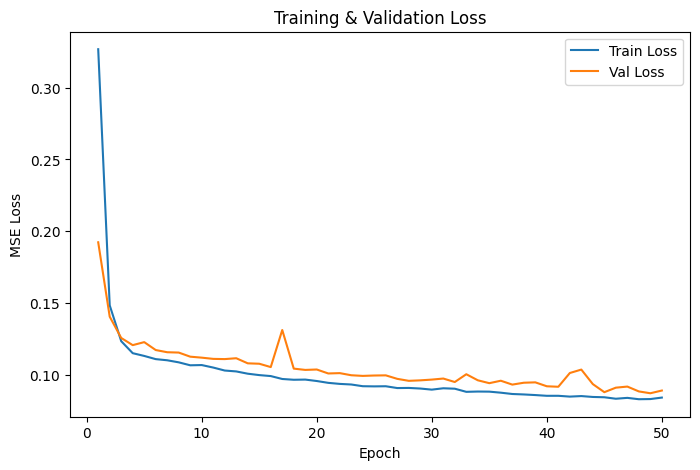

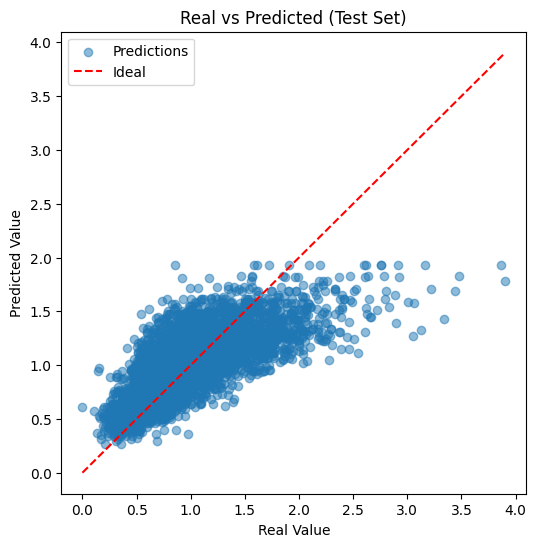

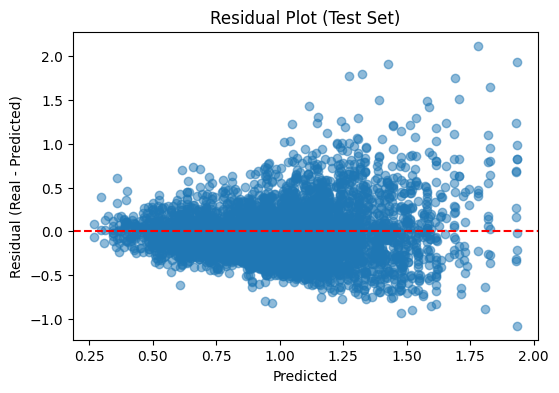

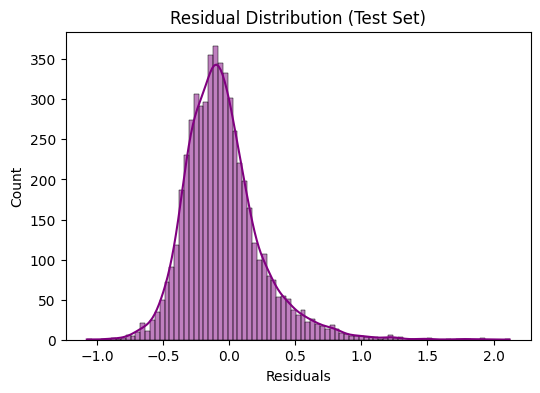

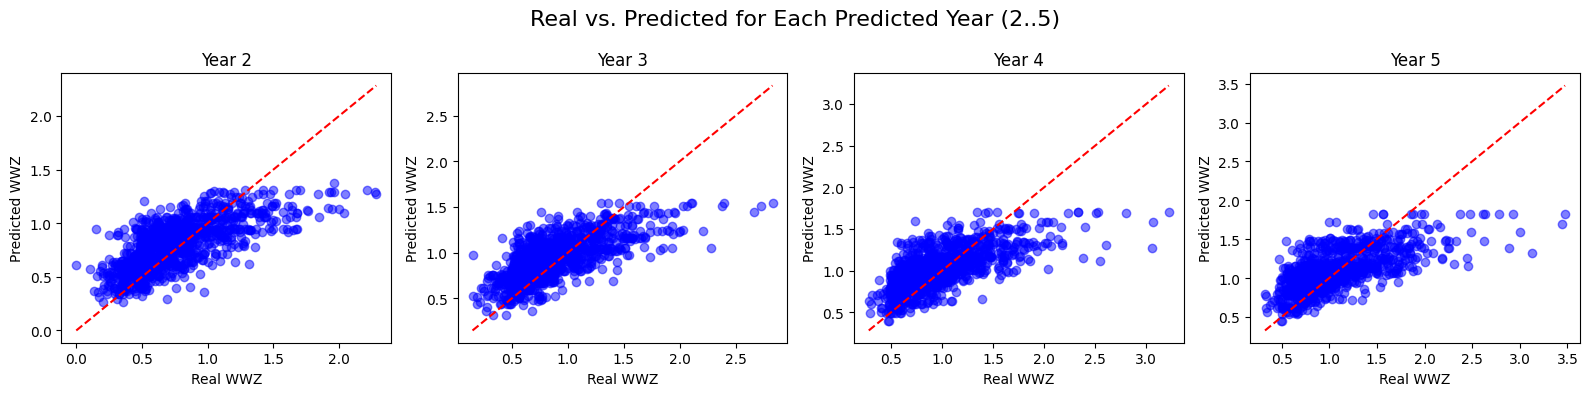

Per-Year Metrics (Years 2..5):
   Year       MSE      RMSE       MAE          MAPE        R2
0     2  0.060459  0.245884  0.189040  2.485760e+12  0.477536
1     3  0.072089  0.268494  0.207182  2.795545e-01  0.449749
2     4  0.089811  0.299685  0.229380  2.636233e-01  0.411463
3     5  0.102374  0.319960  0.240735  2.537434e-01  0.423230
Predicted earnings for P_WWZ_P1 to P_WWZ_P5: [1.161371111869812, 1.4303423166275024, 1.5785959959030151, 1.69083571434021, 1.7821226119995117]


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# ===================================================
# 1. Data Preparation
# ===================================================

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Extract features and targets
static_features = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
targets = ['P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5']

X = graduates_data_copy[static_features].values  # Shape: (N, 4)
y = graduates_data_copy[targets].values         # Shape: (N, 5)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# ===================================================
# 2. Dataset and DataLoader
# ===================================================
class StaticDataset(Dataset):
    """
    A custom PyTorch Dataset for static features.
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets for train, val, test
train_dataset = StaticDataset(X_train, y_train)
val_dataset = StaticDataset(X_val, y_val)
test_dataset = StaticDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ===================================================
# 3. Model Definition
# ===================================================
class StaticModel(nn.Module):
    """
    A simple feedforward neural network for predicting earnings based on static features.
    """
    def __init__(self, input_dim, hidden_dim=64, output_dim=5):
        super(StaticModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of static features
output_dim = y_train.shape[1]  # Number of target variables

model = StaticModel(input_dim=input_dim, hidden_dim=64, output_dim=output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===================================================
# 4. Model Training
# ===================================================
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    # Training Loop
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        preds = model(batch_x)  # Shape: (batch_size, output_dim)
        loss = criterion(preds, batch_y)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_x.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            preds = model(batch_x)
            val_loss = criterion(preds, batch_y)
            total_val_loss += val_loss.item() * batch_x.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# ===================================================
# 5. Evaluation on the Test Set
# ===================================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

test_preds = torch.cat(test_preds_list, dim=0).numpy()  # Shape: (N_test, output_dim)
test_real = torch.cat(test_y_list, dim=0).numpy()       # Shape: (N_test, output_dim)

# Flatten for metrics
test_preds_flat = test_preds.flatten()
test_real_flat = test_real.flatten()

# -------------------------------------
# 5.1. Metrics
# -------------------------------------
mse  = mean_squared_error(test_real_flat, test_preds_flat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_real_flat, test_preds_flat)
mape = mean_absolute_percentage_error(test_real_flat, test_preds_flat)
r2   = r2_score(test_real_flat, test_preds_flat)

print("\n*** Final Evaluation on Test Set ***")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test R^2:  {r2:.4f}")

# -------------------------------------
# 5.2. Plots
# -------------------------------------
# (A) Training vs Validation Loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# (B) Real vs. Predicted scatter (Test Set)
plt.figure(figsize=(6,6))
plt.scatter(test_real_flat, test_preds_flat, alpha=0.5, label='Predictions')
plt.plot(
    [test_real_flat.min(), test_real_flat.max()],
    [test_real_flat.min(), test_real_flat.max()],
    'r--',
    label='Ideal'
)
plt.title("Real vs Predicted (Test Set)")
plt.xlabel("Real Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

# (C) Residuals: Real - Predicted
residuals = test_real_flat - test_preds_flat

plt.figure(figsize=(6,4))
plt.scatter(test_preds_flat, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Real - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()

# (D) Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

# Years that are predicted
predicted_years = [2, 3, 4, 5]

# 1) Create a plot with subplots for each predicted year
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Real vs. Predicted for Each Predicted Year (2..5)", fontsize=16)

for i, ax in enumerate(axes):
    year = predicted_years[i]       # 2, 3, 4, 5
    real_vals = test_real[:, i]     # Column i in test_real
    pred_vals = test_preds[:, i]    # Column i in test_preds

    ax.scatter(real_vals, pred_vals, alpha=0.5, color='blue')
    ax.plot(
        [real_vals.min(), real_vals.max()],
        [real_vals.min(), real_vals.max()],
        'r--'
    )
    ax.set_title(f"Year {year}")
    ax.set_xlabel("Real WWZ")
    ax.set_ylabel("Predicted WWZ")

plt.tight_layout()
plt.show()


# 2) Create a per-year metrics table (MSE, RMSE, MAE, MAPE, R2)
metrics_rows = []
for i, year in enumerate(predicted_years):
    # Extract real and predicted columns
    real_vals = test_real[:, i]
    pred_vals = test_preds[:, i]
    
    mse  = mean_squared_error(real_vals, pred_vals)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(real_vals, pred_vals)
    mape = mean_absolute_percentage_error(real_vals, pred_vals)
    r2   = r2_score(real_vals, pred_vals)
    
    metrics_rows.append({
        "Year": year,
        "MSE":  mse,
        "RMSE": rmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2
    })

df_metrics = pd.DataFrame(metrics_rows)
print("Per-Year Metrics (Years 2..5):")
print(df_metrics)

# ===================================================
# 6. Prediction Function
# ===================================================
def predict_earnings(model, input_features):
    """
    Predict earnings for P_WWZ_P1 to P_WWZ_P5 based on input features.

    Args:
        model (nn.Module): Trained model.
        input_features (dict): Dictionary with static features.

    Returns:
        list: Predicted earnings for P_WWZ_P1 to P_WWZ_P5.
    """
    feature_vector = torch.tensor([
        input_features['P_WOJ'],
        input_features['P_POZIOM'],
        input_features['P_FORMA'],
        input_features['Dziedzina']
    ], dtype=torch.float32).unsqueeze(0)  # Shape: (1, input_dim)

    model.eval()
    with torch.no_grad():
        predictions = model(feature_vector).squeeze(0).numpy()  # Shape: (output_dim,)

    return predictions.tolist()

# Example usage
input_features = {
    'P_WOJ': 0,      # e.g. Some voivodeship code
    'P_POZIOM': 1,   # e.g. Master's level
    'P_FORMA': 1,    # e.g. Full-time
    'Dziedzina': 4   # e.g. Some field code
    P_WWZ_P1: 3
}

predicted_earnings = predict_earnings(model, input_features)
print("Predicted earnings for P_WWZ_P1 to P_WWZ_P5:", predicted_earnings)


## LSTM - przewidywanie 5 roku

Train size: 8828
Validation size: 1103
Test size: 1104
Epoch [1/10]: Train Loss=0.1341, Val Loss=0.0275
Epoch [2/10]: Train Loss=0.0258, Val Loss=0.0223
Epoch [3/10]: Train Loss=0.0207, Val Loss=0.0185
Epoch [4/10]: Train Loss=0.0187, Val Loss=0.0185
Epoch [5/10]: Train Loss=0.0180, Val Loss=0.0169
Epoch [6/10]: Train Loss=0.0176, Val Loss=0.0174
Epoch [7/10]: Train Loss=0.0171, Val Loss=0.0200
Epoch [8/10]: Train Loss=0.0170, Val Loss=0.0161
Epoch [9/10]: Train Loss=0.0167, Val Loss=0.0226
Epoch [10/10]: Train Loss=0.0166, Val Loss=0.0164

*** Final Test Evaluation (Predicting P_WWZ_P5) ***
MSE:  0.0170
RMSE: 0.1304
MAE:  0.0910
MAPE: 0.0877
R^2:  0.9175


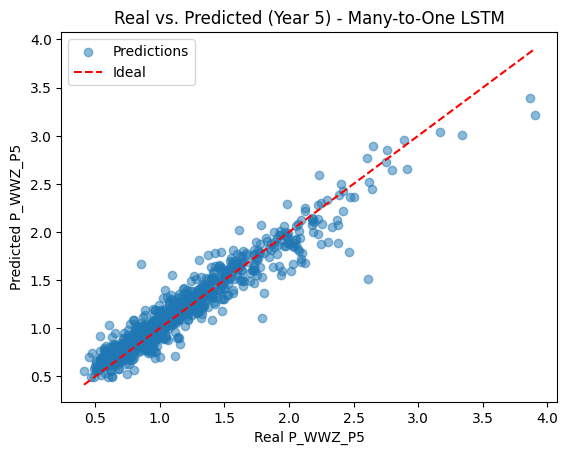

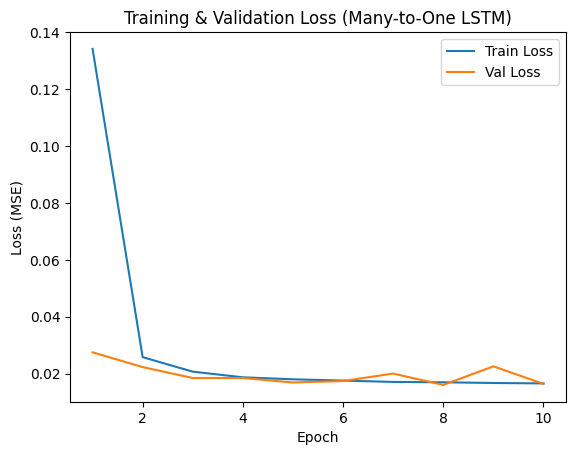

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# =================================================
# 1. Data Preparation
# =================================================

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

def build_seq_many_to_one(row):
    """
    Builds a 4-year sequence (years 1..4) as input,
    with a single target for year 5 (P_WWZ_P5).
    
    Input (X) => shape (4, input_dim)
      X_t = [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, WWZ_t]
    Output (Y) => scalar: P_WWZ_P5
    """
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    wwz_values = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']  # this is the final target (year 5)
    ]
    
    seq_input = []
    # Build 4 timesteps: t = 1..4
    for t in range(4):
        X_t = [
            woj, 
            poziom, 
            forma, 
            dziedz, 
            (t+1), 
            wwz_values[t]
        ]
        seq_input.append(X_t)
    
    # The target is only WWZ_P5
    seq_output = wwz_values[4]  # scalar
    return np.array(seq_input, dtype=np.float32), float(seq_output)

all_X = []
all_y = []

for _, row in graduates_data_copy.iterrows():
    X_seq, y_val = build_seq_many_to_one(row)
    all_X.append(X_seq)
    all_y.append(y_val)

all_X = np.array(all_X, dtype=np.float32)  # shape: (N, 4, 6)
all_y = np.array(all_y, dtype=np.float32)  # shape: (N,)

# -------------------------------------------------
# 1.1 Splitting Data (Train/Val/Test)
# -------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    all_X, all_y,
    test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# =================================================
# 2. Dataset & DataLoader (many-to-one)
# =================================================
class ManyToOneDataset(Dataset):
    """
    A custom PyTorch Dataset for LSTM-based time series
    in a many-to-one scenario (predicting a single value).
    """
    def __init__(self, X, y):
        # Now X, y are already float32
        self.X = torch.from_numpy(X)  # => float32
        self.y = torch.from_numpy(y).unsqueeze(-1)  # => float32, shape (N,1)
    
    def __len__(self):
        return self.X.size(0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ManyToOneDataset(X_train, y_train)
val_dataset   = ManyToOneDataset(X_val,   y_val)
test_dataset  = ManyToOneDataset(X_test,  y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# =================================================
# 3. LSTM Model Definition (Many-to-One)
# =================================================
class ManyToOneLSTM(nn.Module):
    """
    LSTM in a many-to-one configuration:
    We want the final hidden state -> a single value.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(ManyToOneLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        # We'll take only the last hidden state
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        x => shape (batch_size, seq_len=4, input_dim=6)
        We want the final hidden state => (batch_size, hidden_dim).
        """
        # lstm_out => (batch, seq_len, hidden_dim), 
        # h_n => (num_layers, batch, hidden_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Typically, we take h_n from the last layer: h_n[-1]
        # shape => (batch, hidden_dim)
        # because batch_first=True and num_layers=1 => h_n is (1, batch, hidden_dim).
        last_hidden = h_n[-1]  # shape => (batch_size, hidden_dim)
        
        out = self.fc(last_hidden)  # => shape (batch_size, 1)
        return out.squeeze(-1)      # => shape (batch_size,)

# Initialize the model
input_dim = X_train.shape[2]  # 6
model = ManyToOneLSTM(input_dim=input_dim, hidden_dim=64, num_layers=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =================================================
# 4. Training
# =================================================
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        preds = model(batch_x)  # shape => (batch_size,)
        # batch_y is shape => (batch_size,1), so let's squeeze
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * batch_x.size(0)
    
    epoch_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y.squeeze(-1))
            total_val_loss += loss.item() * batch_x.size(0)
    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}]: "
          f"Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}")

# =================================================
# 5. Evaluation on the Test
# =================================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y.squeeze(-1))

test_preds_cat = torch.cat(test_preds_list, dim=0).numpy()   # shape => (N_test,)
test_y_cat     = torch.cat(test_y_list,   dim=0).numpy()     # shape => (N_test,)

# -------------------------------------
# 5.1. Metrics
# -------------------------------------
mse  = mean_squared_error(test_y_cat, test_preds_cat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_y_cat, test_preds_cat)
mape = mean_absolute_percentage_error(test_y_cat, test_preds_cat)
r2   = r2_score(test_y_cat, test_preds_cat)

print("\n*** Final Test Evaluation (Predicting P_WWZ_P5) ***")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R^2:  {r2:.4f}")

# Optionally: Plot predictions vs. real on the test set
plt.figure()
plt.scatter(test_y_cat, test_preds_cat, alpha=0.5, label="Predictions")
plt.plot([test_y_cat.min(), test_y_cat.max()],
         [test_y_cat.min(), test_y_cat.max()],
         'r--', label="Ideal")
plt.xlabel("Real P_WWZ_P5")
plt.ylabel("Predicted P_WWZ_P5")
plt.title("Real vs. Predicted (Year 5) - Many-to-One LSTM")
plt.legend()
plt.show()

# Plot training curves
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss (Many-to-One LSTM)")
plt.legend()
plt.show()


In [91]:
def predict_year5_auto(
    model,
    graduates_data,
    input_features
):
    """
    Automatically retrieves the median WWZ values for years 1..4 (P_WWZ_P1..P4) 
    from the graduates_data, then feeds that 4-step sequence into a 
    many-to-one LSTM model to predict P_WWZ_P5.
    
    Additionally, it compares the predicted value to the actual median P_WWZ_P5
    in the dataset and computes the percentage difference.
    
    Args:
        model (nn.Module):
            A trained LSTM model (many-to-one) that outputs a single float for year 5.
        graduates_data (pd.DataFrame):
            The dataset containing columns:
                P_WOJ, P_POZIOM, P_FORMA, Dziedzina, P_WWZ_P1..P5
        input_features (dict):
            A dictionary containing ONLY the categorical features:
                {
                    'P_WOJ': int,
                    'P_POZIOM': int,
                    'P_FORMA': int,
                    'Dziedzina': int
                }
    
    Returns:
        dict:
            {
                "predicted": float,        # predicted WWZ for year 5
                "actual_median": float,    # median WWZ for year 5 from the dataset
                "difference_pct": float    # difference in percentage
            }
            If the filtered subset is empty, all fields are set to None.
    """
    model.eval()

    # 1) Filter the graduates_data to find the subset matching input_features
    #    for P_WOJ, P_POZIOM, P_FORMA, Dziedzina.
    filtered_data = graduates_data[
        (graduates_data['P_WOJ'] == input_features['P_WOJ']) &
        (graduates_data['P_POZIOM'] == input_features['P_POZIOM']) &
        (graduates_data['P_FORMA'] == input_features['P_FORMA']) &
        (graduates_data['Dziedzina'] == input_features['Dziedzina'])
    ]

    # 2) Check if subset is empty
    if filtered_data.empty:
        return {
            "predicted": None,
            "actual_median": None,
            "difference_pct": None
        }

    # 3) Calculate median for P_WWZ_P1..P5 in this subset
    #    We'll use these medians as the "known" years 1..4 for the input sequence,
    #    and also compare predicted vs. the median of year 5.
    median_wwz_1 = filtered_data['P_WWZ_P1'].median()
    median_wwz_2 = filtered_data['P_WWZ_P2'].median()
    median_wwz_3 = filtered_data['P_WWZ_P3'].median()
    median_wwz_4 = filtered_data['P_WWZ_P4'].median()
    median_wwz_5 = filtered_data['P_WWZ_P5'].median()

    # 4) Build the 4-timestep sequence for the model
    #    shape => (1,4,6), because batch_first=True
    import torch
    
    seq_input = []
    known_wwz = [median_wwz_1, median_wwz_2, median_wwz_3, median_wwz_4]
    for t in range(4):
        # t => 0..3, but actual year is t+1 => 1..4
        x_t = [
            float(input_features['P_WOJ']),
            float(input_features['P_POZIOM']),
            float(input_features['P_FORMA']),
            float(input_features['Dziedzina']),
            float(t + 1),
            float(known_wwz[t])
        ]
        seq_input.append(x_t)
    
    seq_tensor = torch.tensor([seq_input], dtype=torch.float32)

    # 5) Forward pass to predict year 5
    with torch.no_grad():
        predicted_tensor = model(seq_tensor)  # shape => (batch=1,)
        predicted_wwz_5 = predicted_tensor.item()  # single float
    
    # 6) Compare with actual median for year 5
    if median_wwz_5 is None or median_wwz_5 == 0:
        difference_pct = None
    else:
        difference_pct = ((predicted_wwz_5 - median_wwz_5) / median_wwz_5) * 100.0
    
    # 7) Return results as a dictionary
    return {
        "predicted": predicted_wwz_5,
        "actual_median": median_wwz_5,
        "difference_pct": difference_pct
    }


In [92]:
# Suppose your input features only have categorical fields:
input_features = {
    'P_WOJ': 0,
    'P_POZIOM': 0,
    'P_FORMA': 1,
    'Dziedzina': 1
}

result = predict_year5_auto(model, graduates_data, input_features)
pred_val = result["predicted"]
actual_val = result["actual_median"]
diff = result["difference_pct"]

if pred_val is not None:
    print(f"Predicted year 5 WWZ: {pred_val:.4f}")
    print(f"Median year 5 WWZ: {actual_val:.4f}")
    print(f"Difference in %: {diff:.2f}")
else:
    print("No data available for the given input_features.")


Predicted year 5 WWZ: 1.4193
Median year 5 WWZ: 1.4280
Difference in %: -0.61


## LSTM Bidirectional - przewidywanie 5 roku

Train size: 8828
Validation size: 1103
Test size: 1104


/home/jkskw/git/ela_analysis/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25] - Train Loss: 0.0673, Val Loss: 0.0197
Epoch [2/25] - Train Loss: 0.0337, Val Loss: 0.0216
Epoch [3/25] - Train Loss: 0.0292, Val Loss: 0.0185
Epoch [4/25] - Train Loss: 0.0336, Val Loss: 0.0283
Epoch [5/25] - Train Loss: 0.0309, Val Loss: 0.0163
Epoch [6/25] - Train Loss: 0.0284, Val Loss: 0.0217
Epoch [7/25] - Train Loss: 0.0302, Val Loss: 0.0171
Epoch [8/25] - Train Loss: 0.0300, Val Loss: 0.0174
Epoch [9/25] - Train Loss: 0.0279, Val Loss: 0.0168
Epoch [10/25] - Train Loss: 0.0283, Val Loss: 0.0168
Epoch [11/25] - Train Loss: 0.0288, Val Loss: 0.0190
Epoch [12/25] - Train Loss: 0.0266, Val Loss: 0.0173
Epoch [13/25] - Train Loss: 0.0266, Val Loss: 0.0189
Epoch [14/25] - Train Loss: 0.0277, Val Loss: 0.0167
Epoch [15/25] - Train Loss: 0.0261, Val Loss: 0.0166
Epoch [16/25] - Train Loss: 0.0262, Val Loss: 0.0180
Epoch [17/25] - Train Loss: 0.0270, Val Loss: 0.0179
Epoch [18/25] - Train Loss: 0.0255, Val Loss: 0.0167
Epoch [19/25] - Train Loss: 0.0269, Val Loss: 0.0170
Ep

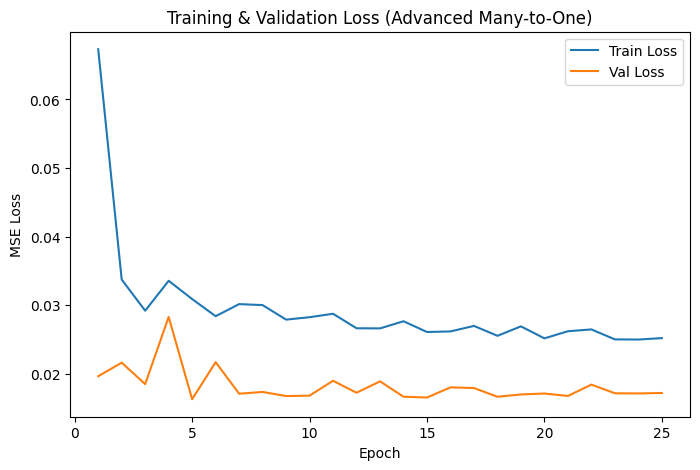

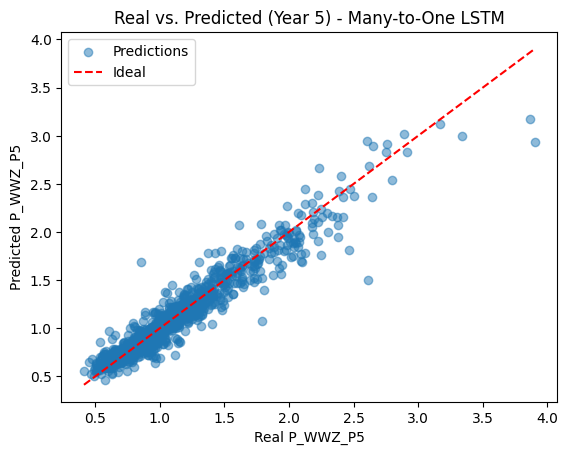

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# =======================================
# 1. Data Preparation (same as before)
# =======================================
graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

def build_seq_many_to_one(row):
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    wwz_values = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']  # final target
    ]
    
    seq_input = []
    for t in range(4):
        X_t = [
            woj, 
            poziom, 
            forma, 
            dziedz, 
            (t+1), 
            wwz_values[t]
        ]
        seq_input.append(X_t)
    
    seq_output = wwz_values[4]  # P_WWZ_P5
    return np.array(seq_input, dtype=np.float32), float(seq_output)

all_X = []
all_y = []
for _, row in graduates_data_copy.iterrows():
    X_seq, y_val = build_seq_many_to_one(row)
    all_X.append(X_seq)
    all_y.append(y_val)

all_X = np.array(all_X, dtype=np.float32)  # shape: (N,4,6)
all_y = np.array(all_y, dtype=np.float32)  # shape: (N,)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_X, all_y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

class ManyToOneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)   # float32
        self.y = torch.from_numpy(y).unsqueeze(-1)  # (N,1)
    def __len__(self):
        return self.X.size(0)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ManyToOneDataset(X_train, y_train)
val_dataset   = ManyToOneDataset(X_val,   y_val)
test_dataset  = ManyToOneDataset(X_test,  y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# =========================================
# 2. Advanced Architecture (Many-to-One)
# =========================================
class AdvancedLSTMModelManyToOne(nn.Module):
    """
    An advanced LSTM architecture in a many-to-one configuration:
    - BatchNorm on the input dimension
    - Multi-layer, bidirectional LSTM with dropout
    - We take the final hidden state from the last layer => single scalar output
    """
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(AdvancedLSTMModelManyToOne, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 1) Batch Normalization
        self.bn = nn.BatchNorm1d(input_dim)
        
        # 2) Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Because it's bidirectional => hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        """
        x.shape => (batch_size, seq_len=4, input_dim)
        
        Many-to-one approach => we want a single final output from 
        the last hidden state, so we'll gather it from (h_n).
        """
        batch_size, seq_length, input_dim = x.size()
        
        # A) Flatten => apply BN => reshape
        # shape => (batch_size * seq_length, input_dim)
        x_2d = x.view(-1, input_dim)    # flatten
        x_bn = self.bn(x_2d)            # batchnorm
        x_bn = x_bn.view(batch_size, seq_length, input_dim)
        
        # B) LSTM forward
        # If bidirectional => h_n has shape (num_layers*2, batch, hidden_dim)
        lstm_out, (h_n, c_n) = self.lstm(x_bn)  
        
        # C) Get the final hidden state from the last layer
        #    h_n shape => (num_layers*2, batch_size, hidden_dim)
        #    We want the last layer => h_n[-2:] if we had multiple layers * 2...
        # But simpler to do: h_n[-2:] for the final layer if it's bidirectional, or
        # index = num_layers*2 - 1 for the top forward, num_layers*2 - 2 for the top backward
        # However, an easy approach: gather the forward/backward last states and cat them.
        
        # For multi-layer bidirectional => top layer is:
        #   forward hidden => h_n[-2]
        #   backward hidden => h_n[-1]
        # We'll cat them horizontally => shape (batch, hidden_dim*2)
        # NOTE: This approach only works if num_layers=3 => final layer is [-2], [-1].
        forward_final = h_n[-2]  # last forward
        backward_final = h_n[-1] # last backward
        # shape => (batch_size, hidden_dim)
        
        # Concatenate => (batch, hidden_dim*2)
        final_hidden = torch.cat((forward_final, backward_final), dim=1)
        
        # D) FC => single scalar
        out = self.fc(final_hidden)  # => (batch_size,1)
        return out.squeeze(-1)       # => (batch_size,)

# Initialize
input_dim = X_train.shape[2]  # 6
model = AdvancedLSTMModelManyToOne(
    input_dim=input_dim, 
    hidden_dim=128, 
    num_layers=3, 
    dropout=0.3
)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

# =========================================
# 3. Training
# =========================================
epochs = 25
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)         # shape => (batch_size,)
        loss = criterion(preds, batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * batch_x.size(0)
    
    epoch_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y.squeeze(-1))
            total_val_loss += loss.item() * batch_x.size(0)
    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Step scheduler
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# =========================================
# 4. Test Evaluation
# =========================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y.squeeze(-1))

test_preds_cat = torch.cat(test_preds_list, dim=0).numpy()
test_y_cat     = torch.cat(test_y_list,   dim=0).numpy()

mse  = mean_squared_error(test_y_cat, test_preds_cat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_y_cat, test_preds_cat)
mape = mean_absolute_percentage_error(test_y_cat, test_preds_cat)
r2   = r2_score(test_y_cat, test_preds_cat)

print("\n*** Final Test Evaluation ***")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R^2:  {r2:.4f}")


# (Optional) Plots
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Val Loss')
plt.title("Training & Validation Loss (Advanced Many-to-One)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Optionally: Plot predictions vs. real on the test set
plt.figure()
plt.scatter(test_y_cat, test_preds_cat, alpha=0.5, label="Predictions")
plt.plot([test_y_cat.min(), test_y_cat.max()],
         [test_y_cat.min(), test_y_cat.max()],
         'r--', label="Ideal")
plt.xlabel("Real P_WWZ_P5")
plt.ylabel("Predicted P_WWZ_P5")
plt.title("Real vs. Predicted (Year 5) - Many-to-One LSTM")
plt.legend()
plt.show()


## PORÓWNANIE LSTM i ELder Model 

In [101]:
input_features = {
    'P_WOJ': 0,
    'P_POZIOM': 1,
    'P_FORMA': 1,
    'Dziedzina': 4
}

result_old = predict_year5_old(model_old, graduates_data_copy, input_features)

pred_val_old = result_old["predicted"]
actual_val_old = result_old["actual_median"]
diff_old = result_old["difference_pct"]

if pred_val_old is not None:
    print("Model Stary:")
    print(f"Predicted year 5 WWZ: {pred_val_old:.4f}")
    print(f"Median year 5 WWZ: {actual_val_old:.4f}")
    print(f"Difference in %: {diff_old:.2f}")
else:
    print("No data available for the given input_features.")


result = predict_year5_auto(model, graduates_data, input_features)
pred_val = result["predicted"]
actual_val = result["actual_median"]
diff = result["difference_pct"]

if pred_val is not None:
    print("\nLSTM")
    print(f"Predicted year 5 WWZ: {pred_val:.4f}")
    print(f"Median year 5 WWZ: {actual_val:.4f}")
    print(f"Difference in %: {diff:.2f}")
else:
    print("No data available for the given input_features.")


Model Stary:
Predicted year 5 WWZ: 2.2363
Median year 5 WWZ: 2.1221
Difference in %: 5.38

LSTM
Predicted year 5 WWZ: 2.0823
Median year 5 WWZ: 2.1221
Difference in %: -1.88
